# ResNet Ablation Study


## 라이브러리 불러오기

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import os
import zipfile
import shutil
from tqdm import tqdm

In [2]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
homedir = os.getcwd()

### 데이터 불러오기 
캐글에서 dogs vs cats 데이터세트를 불러와 압축을 풀었다.

In [4]:
# with zipfile.ZipFile(homedir+"/dogs-vs-cats/train.zip","r") as z:
#     z.extractall(".")
    
# with zipfile.ZipFile(homedir+"/dogs-vs-cats/test1.zip","r") as z:
#     z.extractall(".")
    
# os.listdir(".")

In [5]:
# os.mkdir('cats')
# os.mkdir('dogs')

In [6]:
# path = "train"

# dirs = [each for each in os.listdir(path)]

# for _ in tqdm(dirs):
#     folder = _.split(".")[0]
#     if folder=='cat':
#         shutil.move(path+"/"+_, "cats")
#     else:
#         shutil.move(path+"/"+_, "dogs")

In [7]:
# shutil.move('cats','train')
# shutil.move('dogs','train')

## 데이터 세트 전처리

In [8]:
IMAGE_SIZE=224
BATCH_SIZE=32 
CHANNELS=3
EPOCH=100

In [9]:
# 폴더로 정리된 데이터를 데이터세트로
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "train",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE)

Found 25000 files belonging to 2 classes.


In [10]:
# 커널이 죽어서 데이터 수를 줄여 모델의 성능만 확인해보자.
dataset=dataset.take(int(0.1*len(dataset)))
# 폴더 이름이 클래스 이름이 된다. 
class_names=dataset.class_names
class_names


['cats', 'dogs']

In [11]:
def get_dataset_partitions(ds,shuffle=True,shuffle_size=10000):
    size=len(ds)

    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
    
    train_ds=ds.take(int(size*0.8)) # 데이터의 80% 를 학습데이터
   
    t=(ds.skip(int(size*0.8)))
    val_ds=t.skip(int(0.5*len(t))) # 데이터의 10% 검증데이터
    test_ds=t.take(int(0.5*len(t))) # 데이터의 10% 시험데이터
    
    return train_ds,test_ds,val_ds

In [12]:
train_num = int(len(dataset)*BATCH_SIZE * 0.8)
test_num = int(len(dataset)*BATCH_SIZE * 0.1)
val_num = int(len(dataset)*BATCH_SIZE * 0.1)

In [13]:
ds_train,ds_test,ds_val=get_dataset_partitions(dataset)

ds_train=ds_train.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
ds_validation=ds_val.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
ds_test=ds_test.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [14]:
resize_and_rescale=tf.keras.Sequential([
    keras.layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    keras.layers.experimental.preprocessing.Rescaling(1.0/255)])

In [15]:
data_augmentation = tf.keras.Sequential([
    keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    keras.layers.experimental.preprocessing.RandomRotation(0.2)])

## ResNet 모델 구성

In [16]:
def build_resnet(input_shape, is_50=True, is_plain=False):
    input_layer = keras.layers.Input(shape=input_shape)
    x = resize_and_rescale(input_layer)
    x = data_augmentation(x)
    x = keras.layers.Conv2D(filters=64,kernel_size=7,strides=2,padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.activations.relu(x)
    x = keras.layers.MaxPooling2D(pool_size=3,strides=2,padding='same')(x)

    for block_num, (n,f) in enumerate(zip([3,4,6,3],[64,128,256,512])):
        for i in range(n):
            if not is_50:
                residual = x
                x = keras.layers.Conv2D(f,3,padding='same',name=f'block{block_num}_1_conv{i}')(x)
                x = keras.layers.BatchNormalization()(x)
                x = keras.activations.relu(x)
                x = keras.layers.Conv2D(f,3,padding='same',name=f'block{block_num}_2_conv{i}')(x)
                x = keras.layers.BatchNormalization()(x)
                if not is_plain:
                    f_num = residual.shape.as_list()[-1]
                    if f_num != f:
                        residual = keras.layers.Conv2D(f,1,strides=1,padding="same")(residual)
                        residual = keras.layers.BatchNormalization()(residual)
                    x = keras.layers.Add()([x,residual])
                    x = keras.activations.relu(x)
            else:
                residual = x
                x = keras.layers.Conv2D(f,1,padding='same',name=f'block{block_num}_1_conv{i}')(x)
                x = keras.layers.BatchNormalization()(x)
                x = keras.activations.relu(x)
                x = keras.layers.Conv2D(f,3,padding='same',name=f'block{block_num}_2_conv{i}')(x)
                x = keras.layers.BatchNormalization()(x)
                x = keras.activations.relu(x)
                x = keras.layers.Conv2D(f*4,1,padding='same',name=f'block{block_num}_3_conv{i}')(x)
                x = keras.layers.BatchNormalization()(x)
                if not is_plain:
                    f_num = residual.shape.as_list()[-1]
                    if f_num != f*4:
                        residual = keras.layers.Conv2D(f*4,1,strides=1,padding="same")(residual)
                        residual = keras.layers.BatchNormalization()(residual)
                    x = keras.layers.Add()([x,residual])
                    x = keras.activations.relu(x)
        if block_num != 3:
            x = keras.layers.MaxPooling2D(pool_size=2,name=f'block{block_num}_pooling')(x)

    output = keras.layers.AveragePooling2D(padding = 'same')(x)
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(10, activation='softmax', name='predictions')(output)

    model = keras.Model(
        inputs=input_layer,
        outputs=output
    )
    return model

In [17]:
Plain_34 = build_resnet((IMAGE_SIZE, IMAGE_SIZE, CHANNELS), is_50=False, is_plain=True)
ResNet_34 = build_resnet((IMAGE_SIZE, IMAGE_SIZE, CHANNELS), is_50=False, is_plain=False)
Plain_50 = build_resnet((IMAGE_SIZE, IMAGE_SIZE, CHANNELS), is_50=True, is_plain=True)
ResNet_50 = build_resnet((IMAGE_SIZE, IMAGE_SIZE, CHANNELS), is_50=True, is_plain=False)

In [18]:
Plain_34.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 64)      256       
_________________________________________________________________
tf.nn.relu (TFOpLambda)      (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 56, 56, 64)        0     

## Plain-34 VS ResNet 34

In [19]:
Plain_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer= keras.optimizers.Adam(),
    metrics=['accuracy'])

history_plain_34 = Plain_34.fit(
    ds_train,
    epochs=EPOCH,
    validation_data=ds_validation,
    verbose=1,
    use_multiprocessing=True)

Epoch 1/100
62/62 [==============================] - 22s 224ms/step - loss: 1.5162 - accuracy: 0.4718 - val_loss: 62161.9062 - val_accuracy: 0.4766
Epoch 2/100
62/62 [==============================] - 11s 181ms/step - loss: 1.1392 - accuracy: 0.5076 - val_loss: 1075.2473 - val_accuracy: 0.5117
Epoch 3/100
62/62 [==============================] - 11s 178ms/step - loss: 1.0588 - accuracy: 0.5181 - val_loss: 0.9590 - val_accuracy: 0.5547
Epoch 4/100
62/62 [==============================] - 11s 178ms/step - loss: 0.9360 - accuracy: 0.5161 - val_loss: 8.5411 - val_accuracy: 0.4766
Epoch 5/100
62/62 [==============================] - 11s 173ms/step - loss: 1.0642 - accuracy: 0.4950 - val_loss: 1.6707 - val_accuracy: 0.5391
Epoch 6/100
62/62 [==============================] - 11s 172ms/step - loss: 0.9051 - accuracy: 0.5101 - val_loss: 42.2888 - val_accuracy: 0.4844
Epoch 7/100
62/62 [==============================] - 11s 173ms/step - loss: 0.8803 - accuracy: 0.5161 - val_loss: 19.3153 - val_

In [20]:
ResNet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer= keras.optimizers.Adam(),
    metrics=['accuracy'])

history_ResNet_34 = ResNet_34.fit(
    ds_train,
    epochs=EPOCH,
    validation_data=ds_validation,
    verbose=1,
    use_multiprocessing=True)

Epoch 1/100
62/62 [==============================] - 15s 193ms/step - loss: 2.5129 - accuracy: 0.4899 - val_loss: 70.3382 - val_accuracy: 0.5195
Epoch 2/100
62/62 [==============================] - 11s 185ms/step - loss: 1.1341 - accuracy: 0.5222 - val_loss: 270.5783 - val_accuracy: 0.4805
Epoch 3/100
62/62 [==============================] - 11s 185ms/step - loss: 1.3171 - accuracy: 0.5247 - val_loss: 9.2727 - val_accuracy: 0.4531
Epoch 4/100
62/62 [==============================] - 11s 185ms/step - loss: 1.0156 - accuracy: 0.5393 - val_loss: 0.9134 - val_accuracy: 0.5508
Epoch 5/100
62/62 [==============================] - 11s 184ms/step - loss: 1.0819 - accuracy: 0.5363 - val_loss: 126.7417 - val_accuracy: 0.4766
Epoch 6/100
62/62 [==============================] - 11s 184ms/step - loss: 1.0192 - accuracy: 0.5605 - val_loss: 53.4397 - val_accuracy: 0.5742
Epoch 7/100
62/62 [==============================] - 11s 184ms/step - loss: 1.0045 - accuracy: 0.5454 - val_loss: 27.6031 - val_ac

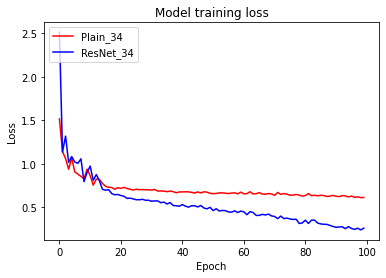

In [21]:
plt.plot(history_plain_34.history['loss'], 'r')
plt.plot(history_ResNet_34.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Plain_34', 'ResNet_34'], loc='upper left')
plt.show()

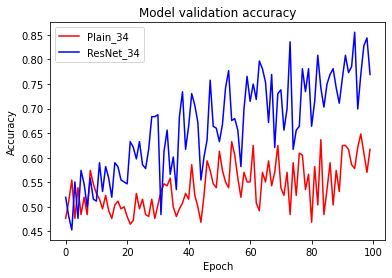

In [22]:
plt.plot(history_plain_34.history['val_accuracy'], 'r')
plt.plot(history_ResNet_34.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Plain_34', 'ResNet_34'], loc='upper left')
plt.show()

## Plain-50 VS ResNet-50

In [23]:
Plain_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer= keras.optimizers.Adam(),
    metrics=['accuracy'])

history_plain_50 = Plain_50.fit(
    ds_train,
    epochs=EPOCH,
    validation_data=ds_validation,
    verbose=1,
    use_multiprocessing=True)

Epoch 1/100
62/62 [==============================] - 24s 297ms/step - loss: 2.6044 - accuracy: 0.4844 - val_loss: 2.4384 - val_accuracy: 0.0000e+00
Epoch 2/100
62/62 [==============================] - 18s 289ms/step - loss: 1.8464 - accuracy: 0.5212 - val_loss: 0.7335 - val_accuracy: 0.5234
Epoch 3/100
62/62 [==============================] - 18s 287ms/step - loss: 1.5734 - accuracy: 0.5040 - val_loss: 0.9358 - val_accuracy: 0.4766
Epoch 4/100
62/62 [==============================] - 18s 286ms/step - loss: 1.3575 - accuracy: 0.5015 - val_loss: 0.9361 - val_accuracy: 0.5547
Epoch 5/100
62/62 [==============================] - 18s 285ms/step - loss: 0.9245 - accuracy: 0.5010 - val_loss: 0.8263 - val_accuracy: 0.5234
Epoch 6/100
62/62 [==============================] - 18s 286ms/step - loss: 0.8121 - accuracy: 0.5076 - val_loss: 0.9806 - val_accuracy: 0.4922
Epoch 7/100
62/62 [==============================] - 18s 286ms/step - loss: 0.9162 - accuracy: 0.5040 - val_loss: 1.8639 - val_accur

In [24]:
ResNet_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer= keras.optimizers.Adam(),
    metrics=['accuracy'])

history_ResNet_50 = ResNet_50.fit(
    ds_train,
    epochs=EPOCH,
    validation_data=ds_validation,
    verbose=1,
    use_multiprocessing=True)

Epoch 1/100
62/62 [==============================] - 27s 362ms/step - loss: 3.4965 - accuracy: 0.5000 - val_loss: 0.6962 - val_accuracy: 0.4922
Epoch 2/100
62/62 [==============================] - 22s 352ms/step - loss: 3.2338 - accuracy: 0.4894 - val_loss: 14.5254 - val_accuracy: 0.5469
Epoch 3/100
62/62 [==============================] - 22s 349ms/step - loss: 2.2228 - accuracy: 0.5116 - val_loss: 2.7753 - val_accuracy: 0.4766
Epoch 4/100
62/62 [==============================] - 22s 348ms/step - loss: 1.5035 - accuracy: 0.4859 - val_loss: 11.1192 - val_accuracy: 0.5039
Epoch 5/100
62/62 [==============================] - 22s 347ms/step - loss: 1.4468 - accuracy: 0.4960 - val_loss: 12.7400 - val_accuracy: 0.5273
Epoch 6/100
62/62 [==============================] - 22s 348ms/step - loss: 1.3003 - accuracy: 0.5066 - val_loss: 1.3511 - val_accuracy: 0.4844
Epoch 7/100
62/62 [==============================] - 22s 349ms/step - loss: 1.0308 - accuracy: 0.5413 - val_loss: 1.1435 - val_accura

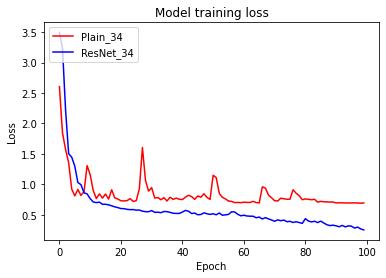

In [27]:
plt.plot(history_plain_50.history['loss'], 'r')
plt.plot(history_ResNet_50.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Plain_34', 'ResNet_34'], loc='upper left')
plt.show()

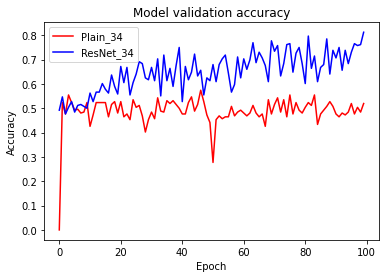

In [28]:
plt.plot(history_plain_50.history['val_accuracy'], 'r')
plt.plot(history_ResNet_50.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Plain_34', 'ResNet_34'], loc='upper left')
plt.show()